In [ ]:
# Incase we have to clear all variables
%reset -f

In [1]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
colourWheel =['#329932',
            '#ff6961',
            'b',
            '#6a3d9a',
            '#fb9a99',
            '#e31a1c',
            '#fdbf6f',
            '#ff7f00',
            '#cab2d6',
            '#6a3d9a',
            '#ffff99',
            '#b15928',
            '#67001f',
            '#b2182b',
            '#d6604d',
            '#f4a582',
            '#fddbc7',
            '#f7f7f7',
            '#d1e5f0',
            '#92c5de',
            '#4393c3',
            '#2166ac',
            '#053061']

from dimer_setup import *
from utils import *

### Example Liouvillian

In [60]:
import time
from heatmap_setup import calculate_steadystate
import numpy as np


w_2 = 1.4*ev_to_inv_cm
bias = 0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 0.01*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 200./pi
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4
wc = 100.
w_0 = 200.
site_basis = True
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)

#



In [ ]:
H, L = get_H_and_L(PARAMS, silent=False, threshold=1e-7, site_basis=site_basis)

In [ ]:
ssL, info = calculate_steadystate(H, L, method="power", persistent=True)
exps = make_expectation_operators(H, PARAMS, site_basis=site_basis)

ss_therm = thermal_state(PARAMS["T_EM"], H[1])
for key, op in exps.items():
    if 'RC' not in key:
        if 'coherence' in key:
            res, therm = (ssL*op).tr(), (ss_therm*op).tr()
        else:
            res, therm = (ssL*op).tr().real, (ss_therm*op).tr().real
        print "{} : {} \t | \t {} \t | \t {}".format(key, res, therm, abs(res - therm))

In [ ]:
print_PARAMS(PARAMS)

###  Helper functions for generating solution estimates, manipulating operators and changing bases

In [ ]:
from scipy.sparse.linalg import eigs
from qutip.cy.spconvert import dense2D_to_fastcsr_fmode

def v0_estimate(H, PARAMS, method=0):
    H = H[1]
    T1, T2 = PARAMS['T_EM'], 0.5*(PARAMS['T_1']+PARAMS['T_2'])
    alpha1, alpha2 = PARAMS['alpha_EM'], 0.5*(PARAMS['alpha_1']+PARAMS['alpha_2'])
    p1 = alpha1/(alpha1+alpha2)
    p2 = alpha2/(alpha1+alpha2)
    p1/= (p1+p2)
    p2/= (p1+p2)
    if method==1:
        # Average two density matrices together
        r1 = (-beta_f(T1)*H).expm(method='sparse')
        r1/ = r1.tr()
        r2 = (-beta_f(T2)*H).expm(method='sparse')
        r2/ = r2.tr()
        rho_approx = r1#+r2
        return qt.operator_to_vector(rho_approx/rho_approx.tr()).data.todense()
    elif method==0:
        # Averages temperatures
        r1 = (-beta_f(abs(2*T1-T2))*H).expm(method='sparse')
        return qt.operator_to_vector(r1/r1.tr()).data.todense()
    else:
        r1 = (-beta_f(T1)*H).expm(method='sparse')
        r2 = (-beta_f(T2)*H).expm(method='sparse')
        rho_approx = 0.5*(r1+r2)+(-beta_f(abs(2*T1-T2))*H).expm(method='sparse')
        return qt.operator_to_vector(rho_approx/rho_approx.tr()).data.todense()

def expectation(rho, expval='site_coherence'):
    e_op = make_expectation_operators(PARAMS)[expval]
    return (rho*e_op).tr()

def vec_to_dm(evec, _H):
    n = int(np.sqrt(evec.shape[0]))
    data = dense2D_to_fastcsr_fmode(evec.reshape((n, n)).T, n, n)
    data = 0.5 * (data + data.H)
    data = qt.Qobj(data, dims=_H[1].dims, isherm=True)
    return data/data.tr()

def L_steadystate(L, tol=1e-8, sigma=1e-12, ncv=18, print_coh=True, v0=None):
    ti = time.time()
    evals, evec = eigs(L, 1, which='LM', sigma=sigma, tol=tol, ncv=ncv, v0=v0)
    print("Steadystate took {:0.3f} seconds".format(time.time() - ti))
    rho = vec_to_dm(evec, H)
    if print_coh:
        print("Coherence is {}".format(expectation(rho)))
    return rho

def _steadystate(H, L, tol=1e-8, sigma=1e-12, ncv=18, print_coh=True, v0=None):
    L_full = -1*qt.liouvillian(H[1], c_ops=[L]).data
    ti = time.time()
    evals, evec = eigs(L_full, 1, which='LM', sigma=sigma, tol=tol, ncv=ncv, v0=v0)
    print("Steadystate took {:0.3f} seconds".format(time.time() - ti))
    rho = vec_to_dm(evec, H)
    if print_coh:
        print("Coherence is {}".format(expectation(rho)))
    return rho

#ev, evec = H[1].
from scipy.linalg import eig, inv
import numpy as np

def sorted_eig(_H):
    if type(_H) == qt.Qobj:
        _H = _H.full()
    eigenValues, eigenVectors = eig(_H)
    idx = eigenValues.argsort()[::-1]   
    return eigenValues[idx], eigenVectors[:,idx]

def to_eigenbasis(op, evals, evecs, evecs_inv):
    if type(op) == qt.Qobj:
        op = op.full()
    A = np.matmul(evecs_inv, op)
    return np.matmul(A, evecs)

def to_site_basis(op, evals, evecs, evecs_inv):
    if type(op) == qt.Qobj:
        op = op.full()
    A = np.matmul(evecs, op)
    return np.matmul(A, evecs_inv)

def array_to_qobj(arr, qobj_in_basis):
    return qt.Qobj(arr, dims=qobj_in_basis.dims)

#print H[1]
eVals, eVecs = H[1].eigenstates()
evecs = np.transpose(np.array([v.dag().full()[0] for v in eVecs]))

#evals, evecs = sorted_eig(H[1])
ti = time.time()
evecs_inv = inv(evecs)
print (time.time() - ti)
D = to_eigenbasis(H[1], evals, evecs, evecs_inv)
H_again = to_site_basis(qt.Qobj(D), evals, evecs, evecs_inv)

assert np.sum(np.around(sorted_eig(qt.Qobj(H_array))[0]-sorted_eig(qt.Qobj(D))[0], 3)) == 0. # get diagonal
assert np.sum(np.around(H_again - H_array, 3)) == 0. # get H again from diagonal

print np.sum(D)
print np.sum(H[1].transform(eVecs).full())


v0 = v0_estimate(H, PARAMS, method=0)
print(np.sum(abs(vec_to_dm(v0, H)-ssL)))
rho = _steadystate(H, L, v0=v0, method="eigen")

v0 = v0_estimate(H, PARAMS, method=1)
print(np.sum(abs(vec_to_dm(v0, H)-ssL)))
rho = _steadystate(H, L, v0=v0)

v0 = v0_estimate(H, PARAMS, method=2)
print(np.sum(abs(vec_to_dm(v0, H)-ssL)))
rho = _steadystate(H, L, v0=v0)

## Inspecting how sparsity and $\textit{chopping}$ affect structure and solution time

In [ ]:
H, L = get_H_and_L(PARAMS, silent=False, threshold=0, site_basis=site_basis)
ssL, infoL = calculate_steadystate(H, L, method="power", persistent=True)
H, L_tidy = get_H_and_L(PARAMS, silent=False, threshold=1e-7, site_basis=site_basis)
ssLt, infoLt = calculate_steadystate(H, L_tidy, method="power", persistent=True)

print "Total error per nz dm element due to chop: {}".format(np.sum((ssL.full()-ssLt.full())**2)/nonzero_elements(ssL)) 

visualise_dense(ssL)
visualise_dense(ssLt)

visualise_sparse(L)
visualise_sparse(L_tidy)


# Excitation restriction

In [61]:
import heatmap_setup as hm
reload(hm)
x_values=[3,4,5,6,7,8] # N
y_values=[0,1,2,3] # exc_diff (exc =  +exc_diff)
method='direct'
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['N_1', 'N_2'],
                            y_axis_parameters=['exc_diff'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name='heatmap_excvN', save_data=True,
                            persistent=False, method=method, threshold=1e-7)

N_1 = 3, N_2 = 3, exc= 3, H_dim=32
Steady state took 0.048 seconds with direct
(32, 32) (32, 32)
Build time: 1.926 	 | 	 Solution time: 0.048 	 | 	 Sigma x -0.0534388846118
N_1 = 4, N_2 = 4, exc= 4, H_dim=52
Steady state took 0.272 seconds with direct
(52, 52) (52, 52)
Build time: 2.641 	 | 	 Solution time: 0.272 	 | 	 Sigma x -0.0519593850024
N_1 = 5, N_2 = 5, exc= 5, H_dim=76
Steady state took 1.541 seconds with direct
(76, 76) (76, 76)
Build time: 5.337 	 | 	 Solution time: 1.541 	 | 	 Sigma x -0.0510444121425
N_1 = 6, N_2 = 6, exc= 6, H_dim=104
Steady state took 9.252 seconds with direct
(104, 104) (104, 104)
Build time: 10.294 	 | 	 Solution time: 9.252 	 | 	 Sigma x -0.0504929508128
N_1 = 7, N_2 = 7, exc= 7, H_dim=136
Steady state took 40.610 seconds with direct
(136, 136) (136, 136)
Build time: 19.559 	 | 	 Solution time: 40.610 	 | 	 Sigma x -0.0501706320981
****************************************************************
The operators took 19.0918939114 and have dimension 172.

In [19]:
ss_obs_array = steadystate_observable(ss_array, PARAMS, 'sigma_x')
print ss_obs_array
print (ss_obs_array[-1]-ss_obs_array[-2])/ss_obs_array[-2]

TypeError: Incompatible Qobj shapes

In [47]:
ss_array1, PARAMS, info_arr = heatmap_loader(8, dir_name="heatmap_excvN")
ss_obs_array = steadystate_observable(ss_array1, PARAMS, 'sigma_x')

[[-0.05530504 -0.05530504]
 [-0.05529627 -0.05529627]
 [        nan         nan]
 [        nan         nan]]


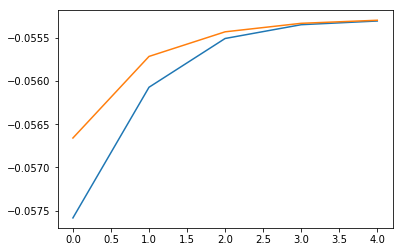

In [49]:
ss_array2, PARAMS, info_arr = heatmap_loader(7, dir_name="heatmap_excvN")
ss_obs_array = steadystate_observable(ss_array2, PARAMS, 'sigma_x')

Converged sigma_x is -0.049756748028
[3.3988101457355819, 1.9644803672863216, 1.1261153912852502, 0.64244499457386373, 0.36550413686990157, 0.20761795641808498, 0.11782791898599156, 0.066835969479457316, 0.037900653460496557, 0.021488786403584256, 0.01218250702188222]


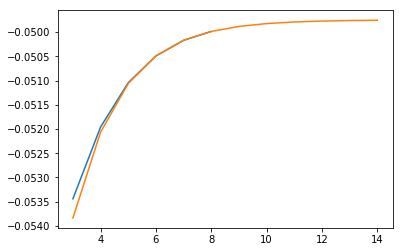

In [118]:
def fit_f(x_vals, y_vals):
    return sp.optimize.curve_fit(f, x_vals, y_vals)[0]

def f(x, a, b, c):
    return a*np.exp(-b*x)-c

def calc_f(x, fp):
    return f(x, fp[0], fp[1], fp[2])

obs_operator='sigma_x'
ss_array, PARAMS, info_arr = heatmap_loader(10, dir_name="heatmap_excvN")
ss_obs_array = steadystate_observable(ss_array, PARAMS, obs_operator)
X_values = np.array(PARAMS['x_values'])
fit_params = fit_f(X_values[3::], ss_obs_array[0][3::])

plt.plot(X_values, ss_obs_array[0])
x_proj = np.arange(3,15)
fit_proj = calc_f(x_proj, fit_params)
print ("Converged {} is {}".format(obs_operator, max(fit_proj)))

percent_change = []
for i in range(len(fit_proj)-1):
    percent_change.append(100*(fit_proj[i]-fit_proj[i+1])/fit_proj[i+1])
plt.plot(x_proj, fit_proj)
#print percent_change

plotting in new style
saved at PLOTS/heatmap_excvN_10.pdf


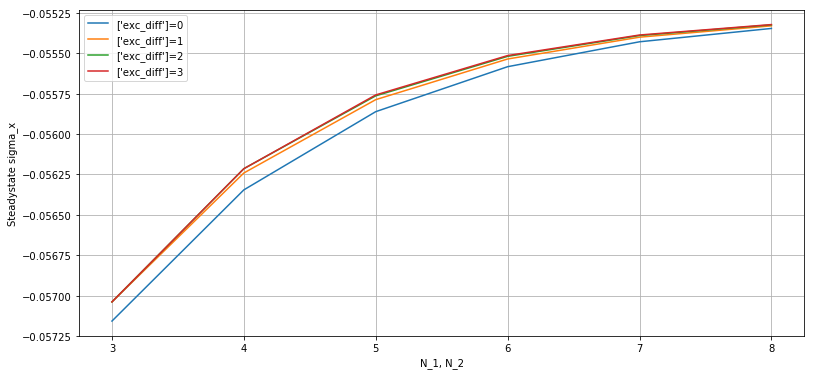

In [63]:
heatmap_plotter(num=10, plot_SD=False, dir_name="heatmap_excvN",
                print_params=False, observable='sigma_x', reverse_x=False)

plotting in new style
saved at PLOTS/heatmap_excvN_11.pdf


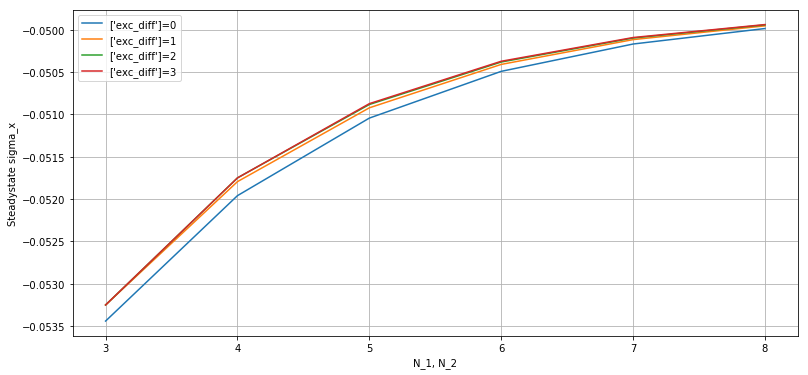

In [62]:
heatmap_plotter(num=11, plot_SD=False, dir_name="heatmap_excvN",
                print_params=False, observable='sigma_x', reverse_x=False)

In [ ]:
ss_info_params = [ss_array, info_array, PARAMS]

#heatmap_plotter(ss_info_params=ss_info_params, plot_SD=False,
#                print_params=False, observable='sigma_x', reverse_x=True)
heatmap_plotter(num=5, plot_SD=False, dir_name="heatmap_excvN",
                print_params=False, observable='sigma_x', reverse_x=False)

In [ ]:
PARAMS['y_values']

In [50]:
def steadystate_observable(ss_array, PARAMS, observable):
    try:
        size = (len(PARAMS['y_values']), len(PARAMS['x_values']))
    except KeyError:
        size = (1,1)
    # deal with the case where N is being changed as an x value
    if 'N_1' in PARAMS['x_axis_parameters']:
        data_array = np.zeros(size)         # Collect data
        N_values = PARAMS['x_values']
        # NEw observable operator for each N value
        for i, N in enumerate(N_values):
            PARAMS.update({'N_1' : N, 'N_2' : N})
            exc = N+PARAMS['exc_diff']
            # Leave it so exc can be fixed or a y_parameter
            if 'exc' in PARAMS['x_axis_parameters']:
                PARAMS.update({'exc': exc})
            _obs_op = make_expectation_operators(PARAMS)[observable]
            for j, y in enumerate(PARAMS['y_values']):
                # the case where exc is on the y axis
                if 'exc_diff' in PARAMS['y_axis_parameters']:
                    PARAMS.update({'exc': N+y})
                    _obs_op = make_expectation_operators(PARAMS)[observable]
                try:
                    #print j,i ,ss_array[j][i].shape, _obs_op.shape
                    data_array[j][i] = (qt.Qobj(ss_array[j][i])*_obs_op).tr().real
                except AttributeError:
                    data_array[j][i] = np.nan
        return data_array
    else:
        # Much simpler if N isn't on the x-axis
        obs_op = make_expectation_operators(PARAMS)[observable]
        f = lambda x: (qt.Qobj(x)*obs_op).tr()
        ss_array = np.reshape(ss_array, (1, size[0]*size[1]))[0]

        data_array = map(f, ss_array)
        data_array = np.array(data_array).reshape(size).real
        return data_array



In [ ]:
plt.imshow(steadystate_observable(ss_array, PARAMS, 'sigma_x'))

In [12]:
# With saved data, we can calculte things differently

def heatmap_loader(num, dir_name="heatmap"):
    directory = 'DATA/'+dir_name+'_'+str(num)
    ss_array = load_obj(directory+'/ss_array')
    PARAMS = load_obj(directory+'/PARAMS')
    info_array = load_obj(directory+'/info_array') # reverse ordering -> lower_N-higher_N
    return ss_array, PARAMS, info_array

def heatmap_plotter(ss_info_params=False, num=-1, plot_SD=True, dir_name="heatmap", 
                     print_params=False, observable='sigma_x', 
                    reverse_x=True):
    if num>=0:
        ss_array, PARAMS, info_array = heatmap_loader(num, dir_name=dir_name)
        
    if ss_info_params:
        if num>=0:
            print "Not loading saved data, using data from arguments instead"
        ss_array,info_array, PARAMS = ss_info_params[0], ss_info_params[1], ss_info_params[2]
    info = info_array[0][0]
    #print info
    
    try:
        # To catch an old bug where these were in "info" not in PARAMS
        keys = ['x_values', 'y_values', 'y_axis_parameters', 'x_axis_parameters']
        PARAMS.update(dict((key, info[key]) for key in keys))
    except Exception as err:
        print "plotting in new style"
    if plot_SD:
        plot_UD_SD(PARAMS["Gamma_1"], PARAMS["alpha_1"], PARAMS["w0_1"], eps=2000.)
    #print PARAMS
    ss_array = steadystate_observable(ss_array, PARAMS, observable)
    
    f, axes = plt.subplots(1,1, figsize=(13,6))
    for i, y_val in enumerate(PARAMS['y_values']):
        x_values = PARAMS['x_values']
        #x_values = x_values[::-1]
        #if reverse_x: # Crazy bug which flips x direction - cba to refactor
        #    x_values = x_values[::-1]
        axes.plot(x_values, ss_array[i], 
                  label=str(PARAMS['y_axis_parameters'])+"="+str(y_val))
    if print_params:
        print_PARAMS(PARAMS)
    
    plt.xlabel(', '.join(PARAMS['x_axis_parameters']))
    plt.ylabel("Steadystate "+observable)
    #plt.ylabel(', '.join(info['y_axis_parameters']))
    plt.legend()
    plt.grid()
    plot_filename = 'PLOTS/'+dir_name+'_'+str(num)+'.pdf'
    plt.savefig(plot_filename)
    print "saved at {}".format(plot_filename)
    plt.show()

In [ ]:
ss_info_params = [ss_array, info_array, PARAMS]

heatmap_plotter(ss_info_params=ss_info_params, plot_SD=False,
                print_params=False, observable='sigma_x', reverse_x=False)

# For N=6, with no 

In [ ]:
"""from heatmap_setup import steadystate

w_2 = 8000.
alpha = 20.

N = 6
pap = alpha_to_pialpha_prop(alpha, w_2)
PARAMS = PARAMS_setup(bias=100., w_2=8000., V = 100., pialpha_prop=pap,
                                 T_EM=6000., T_ph =300.,
                                 alpha_EM=0.1, shift=True,
                                 num_cpus=3, N=N, Gamma=200., w_0=300.,
                                 silent=True, exc_diff=0)
from numpy.linalg import norm
def estimateCondition(M):
    vec = np.ones((1, M.shape[0])).T
    return norm(M.dot(vec), np.inf)"""

# Comparing SS solution methods (direct, inverse power, eigen)

In [ ]:
from qutip import build_preconditioner

def method_plotter(N_vals, data_dict, info_dict, ax1, ax2, linestyle="solid"):
    lw=1.
    if linestyle == 'dashed':
        lw=1.8
    for i, key in enumerate(data_dict.keys()):
        ax1.plot(N_vals, data_dict[key], label=key, color=colourWheel[i], ls=linestyle, linewidth=lw)
        #print info_dict[key]
        ax2.plot(N_vals, info_dict[key], label=key, color=colourWheel[i], ls=linestyle, linewidth=lw)
    ax1.legend()
    ax2.legend()
    ax1.set_ylabel("Coherence")
    ax2.set_ylabel("Solution time")


def method_comparison(N_i, N_f, plot=False, site_basis=True):
    methods = ['direct']
    data_dict = dict()
    info_dict = dict()
    N_vals = range(N_i, N_f)
    for exc_diff in [0,3,4]:
        for N in N_vals:
            PARAMS.update({'N_1':N, 'N_2':N, 'exc':int(2*N-exc_diff)})
            H, L = get_H_and_L(PARAMS,silent=False, threshold=1e-7, site_basis=site_basis)
            exps = make_expectation_operators(PARAMS, site_basis=site_basis)
            for method in methods:
                try:
                    M=None

                    if "iterative" in method:
                        ti = time.time()
                        M = build_preconditioner(H[1], [L], use_rcm=True, ILU_MILU='smilu_2')
                        print("Building preconditioner took {} seconds".format(time.time()-ti))
                    ss, full_info = calculate_steadystate(H, L, method=method, persistent=True)
                    info = full_info['solution_time']

                    coh = (exps['sigma_x']*ss).tr().real
                    try:
                        data_dict[exc_diff].append(coh)
                        info_dict[exc_diff].append(info)
                    except KeyError:
                        data_dict[exc_diff] = [coh]
                        info_dict[exc_diff] = [info]
                except Exception as err:
                    print( "{} failed due to : {}".format(method, err))
                    try:
                        data_dict[exc_diff].append(None)
                        info_dict[exc_diff].append(None)
                    except KeyError:
                        data_dict[exc_diff] = [None]
                        info_dict[exc_diff] = [None]
    #if plot:
    #    method_plotter(N_vals, data_dict, info_dict)
    return N_vals, data_dict, info_dict

N_vals, data_dict_sb, info_dict_sb = method_comparison(3,7)
#N_vals, data_dict_eb, info_dict_eb = method_comparison(3,7, site_basis=False)

f, (ax1, ax2) = plt.subplots(2,1, figsize=(10,7))
method_plotter(N_vals, data_dict_sb, info_dict_sb, ax1, ax2)
#method_plotter(N_vals, data_dict_eb, info_dict_eb, ax1, ax2, linestyle="dashed")


# Plotting methods

In [ ]:
heatmap_plotter(2, plot_SD=False, dir_name='heatmap_excvN', 
                     print_params=False, observable='', 
                    reverse_x=True)